NESTML spike frequency adaptation tutorial
==========================================

Welcome to the NESTML spike frequency adaptation (SFA) tutorial. Here, we will go step by step through adding two different types of SFA mechanism to a neuron model, threshold adaptation and an adaptation current [1], and then evaluate how the new models behave in simulation.

This tutorial is a reduced version of https://nestml.readthedocs.io/en/latest/tutorials/spike_frequency_adaptation/nestml_spike_frequency_adaptation_tutorial.html

For more NESTML tutorials, see https://nestml.readthedocs.io/en/latest/tutorials/index.html

#### Table of contents

- [Introduction](#introduction)
- [Threshold-based SFA](#threshold-based-adaptation)
- [Current-based SFA](#current-based-adaptation)

<a name="introduction"></a>

Introduction
------------

A neuron that is stimulated by rectangular current injections initially responds with a high firing rate, followed by a decrease in the firing rate. This phenomenon is called *spike-frequency adaptation* and is usually mediated by slow K<sup>+</sup> currents, such as a Ca<sup>2+</sup>-activated K<sup>+</sup> current [3]. This behaviour is typically modelled in one of two ways:

*Threshold adaptation:* The threshold for generating an action potential is increased every time an action potential occurs. The threshold slowly decays back to its original value.

*Potassium membrane current:* An extra transmembrane current is added to the neuron, that is increased step-wise every time an action potential occurs, and slowly decays back to its original value.

**Quiz:** If a typical point neuron model has a characteristic timescale (in its membrane potential dynamics) of 20&nbsp;ms, what would be good order-of-magnitude estimate to give to the adaptation characteristic timescale? How does refractoriness figure into this?

**Solution:** Considerably longer than the neuron timescale, e.g. 200 ms; refractoriness defines a maximum neuron firing rate; consider maximum and minimum obtained firing rates in the presence of the SFA mechanism.

#### Plotting setup

In [1]:
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt

#### Import NEST and NumPy for simulation

In [2]:
import nest
import numpy as np


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jul 24 2025 05:27:26

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



#### Import NESTML code generator

In [3]:
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

## Generating code with NESTML

We will take a simple current-based integrate-and-fire model with alpha-shaped postsynaptic response kernels (``iaf_psc_alpha``) as the basis for our modifications. First, let's take a look at this base neuron without any modifications.

We will use a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "iaf_psc_alpha_3cc945f". The resulting neuron model name is returned by the function, so we do not have to think about these internals.

### Base model: no adaptation

Let's first make sure that we have all the necessary files.

If you are running this notebook locally or cloned the repository, the NESTML model ``iaf_psc_alpha_neuron.nestml`` is contained in the subdirectory ``models``. You can open NESTML model files in your favourite code editor (check https://github.com/nest/nestml/ for syntax highlighting support). In case you are running this notebook in JupyerLab, you can edit the model files directly in your browser via the "File browser" panel on the left.

**There may be a number of warnings, you can ignore them.**

The code generator runs for a while and returns
- the name of the NEST module created and providing the new model
- the name of the new model

In [4]:
# generate and build code
module_name_no_sfa, neuron_model_name_no_sfa = \
    NESTCodeGeneratorUtils.generate_code_for("nestml_models/iaf_psc_alpha.nestml")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jul 24 2025 05:27:26

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[11,iaf_psc_alpha_neuron_nestml, WARNING, [95:22;95:33]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.
[12,iaf_psc_alpha_neuron_nestml, WARNING, [110:44;110:55]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.


Float.__new__() missing 1 required positional argument: 'num'


#### A first check

In [5]:
module_name_no_sfa

'nestml_26b3514f66eb4b1ebfce93668f1fd6f0_module'

In [6]:
neuron_model_name_no_sfa

'iaf_psc_alpha_neuron_nestml'

- The module name is a bit cryptic to ensure uniqueness of the module name
- Import the module and create a neuron

In [7]:
nest.Install(module_name_no_sfa)


Jan 12 09:40:04 Install [Info]: 
    loaded module nestml_26b3514f66eb4b1ebfce93668f1fd6f0_module


In [8]:
n_nestml = nest.Create("iaf_psc_alpha_neuron_nestml")

### Explore the model in response to current input

In [20]:
def evaluate_neuron(neuron_name, module_name, neuron_parms=None, stimulus_type="constant",
                    mu=500., sigma=0., t_sim=300., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    dt = .1   # [ms]

    nest.ResetKernel()
    nest.Install(module_name)
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    
    if stimulus_type == "constant":
        nest.SetStatus(neuron, "I_e", mu)
        assert sigma == 0.
    elif stimulus_type == "Ornstein-Uhlenbeck":
        nest.SetStatus(neuron, "I_noise0", mu)
        nest.SetStatus(neuron, "sigma_noise", sigma)
    else:
        raise Exception("Unknown stimulus type: " + str(stimulus_type))
    
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    
    nest.Simulate(t_sim)

    mm_events = multimeter.get("events")
    Voltages = mm_events["V_m"]
    tv = mm_events["times"]
    sr_events = spike_recorder.get("events")
    spikes = sr_events['senders']
    ts = sr_events["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()
        plt.show()
        plt.close(fig)

    return ts


Jan 12 09:56:27 Install [Info]: 
    loaded module nestml_26b3514f66eb4b1ebfce93668f1fd6f0_module

Jan 12 09:56:27 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jan 12 09:56:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Jan 12 09:56:27 SimulationManager::run [Info]: 
    Simulation finished.


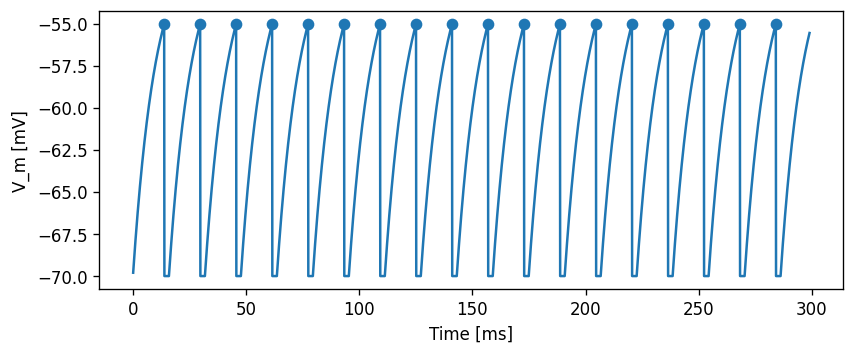

array([ 13.9,  29.8,  45.7,  61.6,  77.5,  93.4, 109.3, 125.2, 141.1,
       157. , 172.9, 188.8, 204.7, 220.6, 236.5, 252.4, 268.3, 284.2])

In [21]:
evaluate_neuron(neuron_model_name_no_sfa, module_name_no_sfa)

### Adjusting the NESTML model

**Task:** Create a new file and name it, for example, ``iaf_psc_alpha_adapt_curr.nestml``. Copy the contents of ``iaf_psc_alpha_neuron.nestml`` and make the following changes.

First, define the parameters:  

```
parameters:
    [...]
    tau_sfa ms = 100 ms
    Delta_I_sfa pA = 100 pA
```

Add the new state variables and initial values:
```
state:
    [...]
    I_sfa pA = 0 pA
```

```
equations:
    [...]
    I_sfa' = -I_sfa / tau_sra
```

and add the new term to the dynamical equation for `V_m`:
```
equations:
    [...]
    function I pA = convolve(I_shape_in, in_spikes) + convolve(I_shape_ex, ex_spikes) - I_sfa + I_e + I_stim
    V_m' = -(V_m - E_L) / Tau + I / C_m
```

Increment the adaptation current whenever the neuron fires:

```
onCondition(V_m >= Theta):
    [...]
    I_sfa += Delta_I_sfa
    emit_spike()
```

In [22]:
# generate and build code
module_name_adapt_curr, neuron_model_name_adapt_curr = \
    NESTCodeGeneratorUtils.generate_code_for("nestml_models/iaf_psc_alpha_adapt_curr.nestml")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jul 24 2025 05:27:26

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[11,iaf_psc_alpha_adapt_curr_neuron_nestml, WARNING, [102:22;102:33]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.
[12,iaf_psc_alpha_adapt_curr_neuron_nestml, WARNING, [118:44;118:55]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``

Float.__new__() missing 1 required positional argument: 'num'



Jan 12 09:57:32 Install [Info]: 
    loaded module nestml_39a0a1c9764d4f299089cfa8ca062e75_module

Jan 12 09:57:32 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jan 12 09:57:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Jan 12 09:57:32 SimulationManager::run [Info]: 
    Simulation finished.


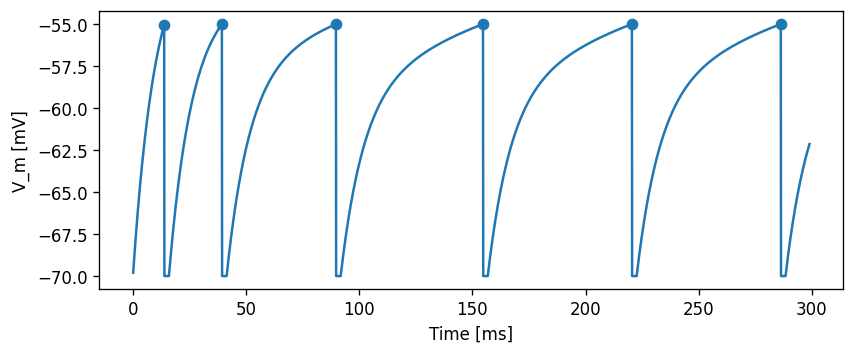

array([ 13.9,  39.4,  89.8, 154.8, 220.6, 286.4])

In [23]:
evaluate_neuron(neuron_model_name_adapt_curr, module_name_adapt_curr)

**Task:** Record and plot the adaptation current $I_{sfa}$.

References
----------

[1] Victor J. Barranca, Han Huang, and Sida Li. The impact of spike-frequency adaptation on balanced network dynamics. Cogn Neurodyn. 2019 Feb; 13(1): 105–120. https://doi.org/10.1007/s11571-018-9504-2